# TCP Listen Backlog Analysis

## Functionalities
- Plot queue length of TCP sockets.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    tcplistenbl-bpftrace.tar.gz
  ...
  [node-n]/
    tcplistenbl-bpftrace.tar.gz
```

## Notebook Configuration

In [8]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2022-04-14-05-26-13"

## Notebook Setup

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from utils.utils import *

experiment_dirpath = os.path.join(os.path.abspath(""), "..", "data", EXPERIMENT_DIRNAME)

## Log Parsing & Processing

In [10]:
# Build data frame
bl = pd.concat([df[2] for df in get_tcplistenbl_df(experiment_dirpath)])

In [11]:
# Extract experiment information
start_time = get_experiment_start_time(experiment_dirpath) - pd.Timedelta(hours=6)
node_names = get_node_names(experiment_dirpath)

In [12]:
# (Re) Build columns
bl["timestamp"] = bl.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
bl["window_1000"] = bl["timestamp"].round(0).multiply(1000)
bl["window_10"] = bl["timestamp"].round(2).multiply(1000)

In [13]:
# (Re) Create index
bl.set_index("timestamp", inplace=True)
bl.sort_index(inplace=True)

## TCP Socket Queue Length

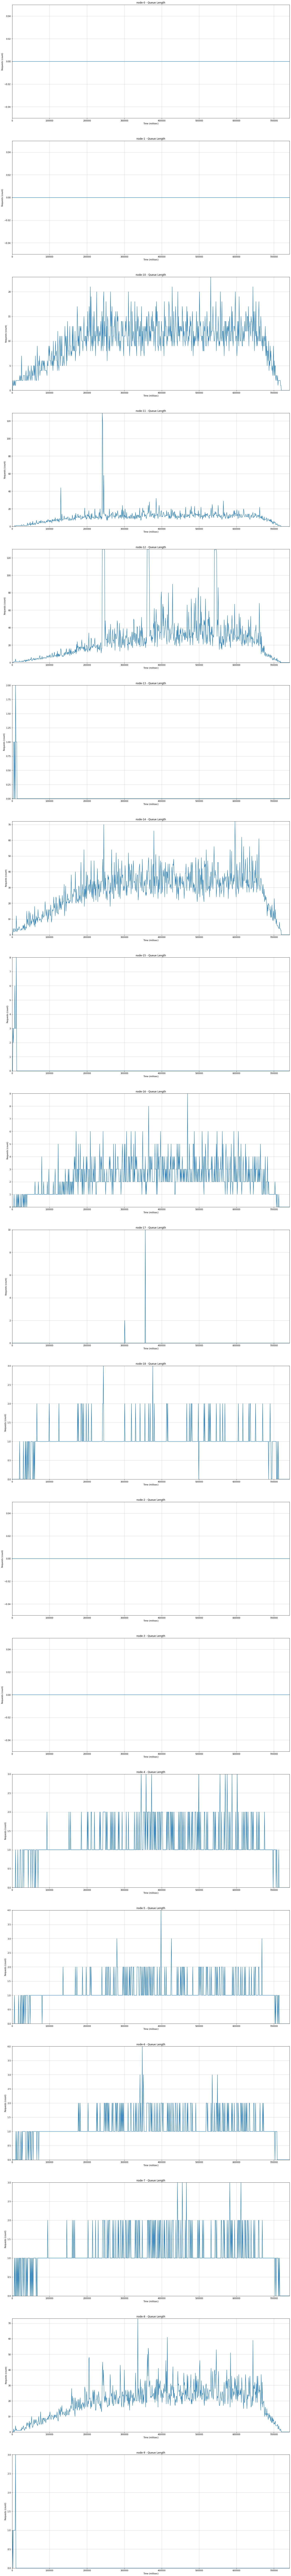

In [14]:
fig = plt.figure(figsize=(24, len(node_names) * 12))
for (i, node_name) in enumerate(sorted(node_names)):
    # Data frame
    df = bl[(bl["node_name"] == node_name)].groupby(["window_1000"])["len"].max().reindex(range(0, int(bl["window_1000"].max()) + 1, 1000), fill_value=0)
    # Plot
    ax = fig.add_subplot(len(node_names), 1, i + 1)
    ax.set_xlim((0, df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.grid(alpha=0.75)
    df.plot(ax=ax, kind="line", title="%s - Queue Length" % node_name, xlabel="Time (millisec)", ylabel="Requests (count)", grid=True, legend=False)

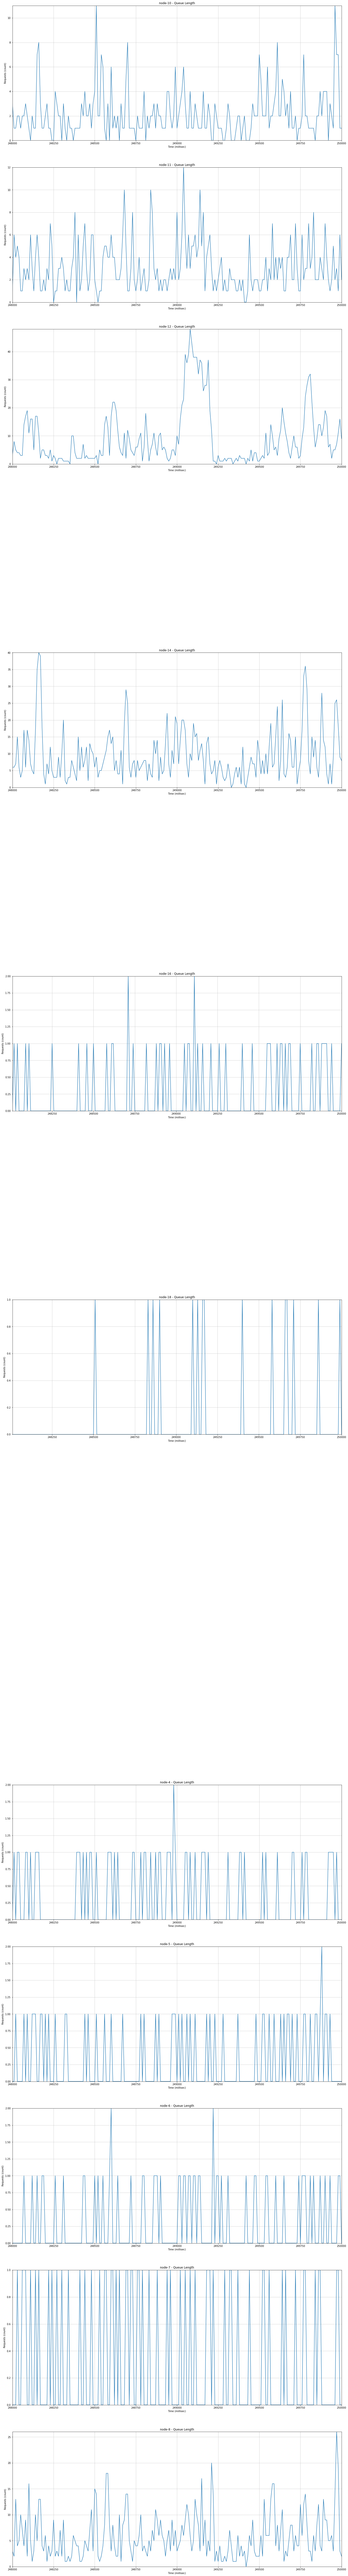

In [16]:
########## ZOOM IN
# Minimum time (in sec)
MIN_TIME = 248
# Maximum time (in sec)
MAX_TIME = 250

if MIN_TIME and MAX_TIME:
    fig = plt.figure(figsize=(24, len(node_names) * 12))
    for (i, node_name) in enumerate(sorted(node_names)):
        # Data frame
        df = bl[(bl["node_name"] == node_name) & (bl.index >= MIN_TIME) & (bl.index <= MAX_TIME)]
        if df.empty:
            continue
        df = df.groupby(["window_10"])["len"].max().reindex(range(int(df["window_10"].min()), int(df["window_10"].max()) + 1, 10), fill_value=0)
        # Plot
        ax = fig.add_subplot(len(node_names), 1, i + 1)
        ax.set_xlim((int(df.index.min()), int(df.index.max())))
        ax.set_ylim((0, df.values.max()))
        ax.grid(alpha=0.75)
        df.plot(ax=ax, kind="line", title="%s - Queue Length" % node_name, xlabel="Time (millisec)", ylabel="Requests (count)", grid=True, legend=False)